In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 29.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# **Import packages**

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import statsmodels as ss
import seaborn as sns
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pmdarima.arima import utils as ut
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

# **Load data**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', encoding="cp1252")
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Các Function cần thiết**
Input : data.csv

Output : Dự đoán 7 ngày sau đó

In [20]:
def clean_data(dataFrame):
  '''
    Input : Dataframe đọc từ file csv
    Output : Chuỗi thời gian thể hiện số lượng hóa đơn theo ngày của cửa hàng
  '''
  #Lọc bỏ những hóa đơn bắt đầu bằng chữ 'C', 'A', hoặc không có doanh thu (UnitPrice==0)
  trans_df = dataFrame[~dataFrame['InvoiceNo'].str.contains('C', na=False)]
  trans_df = trans_df[~trans_df.InvoiceNo.str.contains('A', na=False)]
  trans_df = trans_df[trans_df['UnitPrice']!=0]
  trans_df.reset_index(drop=True)

  #Định dạng lại kiểu của InvoiceDate thành datetime
  trans_df['InvoiceDate'] = pd.to_datetime(trans_df['InvoiceDate']).dt.date

  #Chỉ lấy 2 cột ['InvoiceNo'] và ['InvoiceDate']
  inv_pdt = trans_df[['InvoiceDate', 'InvoiceNo']]
  inv_pdt = inv_pdt.groupby('InvoiceDate').nunique().reset_index()
  inv_pdt = inv_pdt.set_index('InvoiceDate', drop=True)

  #Bổ sung các ngày (nếu còn thiếu) vào chuỗi thời gian
  srt_date = inv_pdt.index.min()
  end_date = inv_pdt.index.max()
  idx = pd.date_range(srt_date, end_date)

  inv_pdt.index = pd.DatetimeIndex(inv_pdt.index)
  inv_pdt = inv_pdt.reindex(idx, fill_value=0)

  #Đặt lại tên cột
  inv_pdt.columns = ['Total invoices']

  return inv_pdt

In [24]:
#Test
clean_df = clean_data(df)
clean.head()

,Total invoices
2010-12-01,127
2010-12-02,142
2010-12-03,68
2010-12-04,0
2010-12-05,88


In [23]:
def decomposit_series(series):
  #Hàm phân tích chuỗi thành 3 thành phần, có cũng được, không có cũng được
  decomp = seasonal_decompose(series)
  fig = decomp.plot()
  fig.set_size_inches(14, 7)

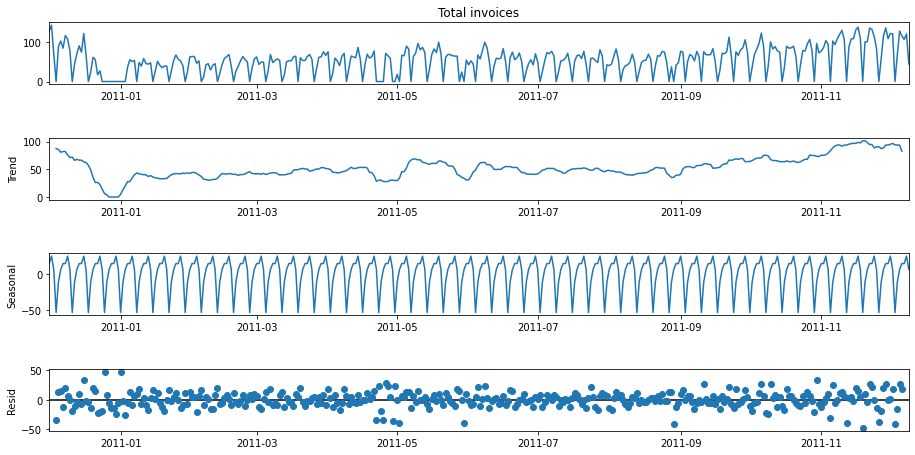

In [25]:
#Test
decomposit_series(clean_df['Total invoices'])

In [55]:
def choose_best_params(timeSeries):
  '''
    Input : Chuoi thoi gian
    Output : Tra ve bo tham so tot nhat cho mo hinh
  '''
  params = []
  season = True
  #Define d and D (Differences)
  d_ = ut.ndiffs(timeSeries, test='adf')
  D_ = ut.nsdiffs(timeSeries, m=7, test='ch')

  if D_ == 0: 
    season = False
  
  #Fit auto_arima function to time series 
  stepwise_fit = auto_arima(timeSeries, start_p = 1, start_q = 1,
                            max_p = 4, max_q = 4, m = 7,
                            start_P = 0, start_Q = 1,
                            max_P = 4, max_Q = 4, seasonal = season,
                            d = d_, D = D_, trace = True,
                            error_action ='ignore')           
  
  # To print the summary
  #stepwise_fit.summary()

  #Get the params
  parameters = stepwise_fit.get_params()
  arima_params = parameters.get('order')
  sarima_params = parameters.get('seasonal_order')
  params.append(arima_params)
  params.append(sarima_params)

  return params

In [57]:
#Test
numbers = choose_best_params(clean_df['Total invoices'])

numbers

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=3132.855, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3298.330, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3194.963, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3185.637, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3296.336, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3217.516, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3119.016, Time=0.65 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3183.005, Time=0.41 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3120.328, Time=1.42 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=3120.614, Time=1.45 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3119.342, Time=1.09 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3165.513, Time=0.83 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=3161.548, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : 

[(3, 0, 0), (1, 1, 1, 7)]

In [67]:
numbers[1]

(1, 1, 1, 7)

In [80]:
def train_model(timeSeries):
  '''
    Input : timeSeries
    Output : model sau khi train
  '''
  X = timeSeries.squeeze().values

  size = int(len(X) * 0.75)
  train, test = X[0:size], X[size:len(X)]
  history = [x for x in train]
  predictions = list()
  residuals = list()
  results = {}

  # walk-forward validation
  for t in range(len(test)):
      model = SARIMAX(endog=history,order=numbers[0],seasonal_order=numbers[1],trend='c',enforce_invertibility=False)
      model_fit = model.fit(maxiter=1000)
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)
      residuals.append(yhat-obs)
      print('predicted=%f, expected=%f' % (yhat, obs))
  model = SARIMAX(endog=history,order=numbers[0],seasonal_order=numbers[1],trend='c',enforce_invertibility=False)
  model_fit = model.fit(maxiter=1000)

  x = {'test' : test}
  results.update(x)
  y = {'pred' : predictions}
  results.update(y)
  z = {'model' : model_fit}
  results.update(z)
  return results

In [81]:
#Test
res = train_model(clean_df['Total invoices'])

predicted=65.151848, expected=52.000000
predicted=77.384195, expected=76.000000
predicted=61.710524, expected=62.000000
predicted=1.338359, expected=0.000000
predicted=40.425319, expected=75.000000
predicted=72.696362, expected=68.000000
predicted=67.360210, expected=67.000000
predicted=69.506937, expected=68.000000
predicted=79.635133, expected=83.000000
predicted=61.545318, expected=50.000000
predicted=1.303917, expected=0.000000
predicted=49.890732, expected=27.000000
predicted=45.692535, expected=71.000000
predicted=67.809372, expected=70.000000
predicted=61.602876, expected=75.000000
predicted=83.484085, expected=112.000000
predicted=71.034751, expected=64.000000
predicted=10.928544, expected=0.000000
predicted=43.576484, expected=75.000000
predicted=78.480520, expected=66.000000
predicted=68.398098, expected=80.000000
predicted=82.897773, expected=85.000000
predicted=94.318541, expected=105.000000
predicted=70.923747, expected=74.000000
predicted=15.524785, expected=0.000000
pred

In [84]:
res['test']

array([ 52,  76,  62,   0,  75,  68,  67,  68,  83,  50,   0,  27,  71,
        70,  75, 112,  64,   0,  75,  66,  80,  85, 105,  74,   0,  35,
        68,  81,  96, 122,  88,   0,  39, 100,  82,  88,  77,  74,   0,
        35,  89,  84,  85,  89,  64,   0,  42,  78,  77,  95, 106,  78,
         0,  96,  72,  77,  85, 103,  94,   0, 102,  93, 108, 119, 129,
       105,   0,  87, 107, 108, 130, 137, 108,   0, 100, 100, 135, 131,
       113,  83,   0,  57, 115, 135, 108, 121, 120,   0,  66, 127, 115,
       106, 120,  44])

In [94]:
def visualize_result(results):
  '''
    Input : ket qua sau khi train model
    Output : In loi RMSE + plot do thi residual + plot test data
  '''
  results['model'].plot_diagnostics(figsize=(14,8))
  plt.show()

  rmse = sqrt(mean_squared_error(results['test'], results['pred']))
  print('Test RMSE: %.3f' % rmse)

  plt.plot(results['test'])
  plt.plot(results['pred'], color='red')
  plt.title('Test result')
  plt.show()

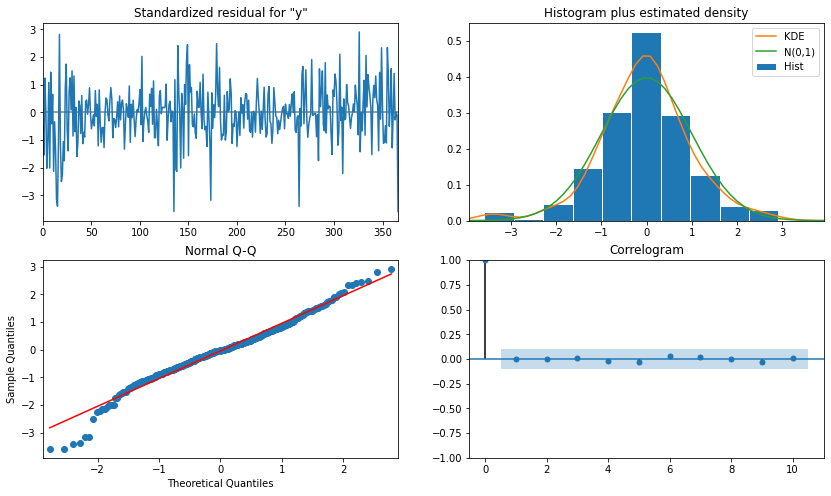

Test RMSE: 18.259


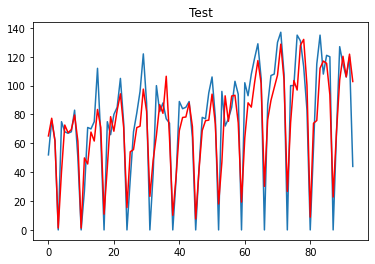

In [93]:
visualize_result(res)

In [99]:
clean_df

,Total invoices
2010-12-01,127
2010-12-02,142
2010-12-03,68
2010-12-04,0
2010-12-05,88
...,...
2011-12-05,127
2011-12-06,115
2011-12-07,106
2011-12-08,120


In [122]:
#Dự đoán cho 7 ngày tới
y = res['model'].predict(1,7)
print(y)

[  0.54774654   0.56990278   0.57468303   0.56009291   0.56464818
   0.56555915 127.55429507]


# **Hàm tổng hợp**

In [4]:
def forecast_func(data):
  '''
  Input : data frame la file csv
  Output : du doan cho 7 ngay toi
  '''

  def clean_data(dataFrame):
    '''
      Input : Dataframe đọc từ file csv
      Output : Chuỗi thời gian thể hiện số lượng hóa đơn theo ngày của cửa hàng
    '''
    #Lọc bỏ những hóa đơn bắt đầu bằng chữ 'C', 'A', hoặc không có doanh thu (UnitPrice==0)
    trans_df = dataFrame[~dataFrame['InvoiceNo'].str.contains('C', na=False)]
    trans_df = trans_df[~trans_df.InvoiceNo.str.contains('A', na=False)]
    trans_df = trans_df[trans_df['UnitPrice']!=0]
    trans_df.reset_index(drop=True)

    #Định dạng lại kiểu của InvoiceDate thành datetime
    trans_df['InvoiceDate'] = pd.to_datetime(trans_df['InvoiceDate']).dt.date

    #Chỉ lấy 2 cột ['InvoiceNo'] và ['InvoiceDate']
    inv_pdt = trans_df[['InvoiceDate', 'InvoiceNo']]
    inv_pdt = inv_pdt.groupby('InvoiceDate').nunique().reset_index()
    inv_pdt = inv_pdt.set_index('InvoiceDate', drop=True)

    #Bổ sung các ngày (nếu còn thiếu) vào chuỗi thời gian
    srt_date = inv_pdt.index.min()
    end_date = inv_pdt.index.max()
    idx = pd.date_range(srt_date, end_date)

    inv_pdt.index = pd.DatetimeIndex(inv_pdt.index)
    inv_pdt = inv_pdt.reindex(idx, fill_value=0)

    #Đặt lại tên cột
    inv_pdt.columns = ['Total invoices']

    return inv_pdt
##################################################

  def decomposit_series(series):
    #Hàm phân tích chuỗi thành 3 thành phần, có cũng được, không có cũng được
    decomp = seasonal_decompose(series)
    fig = decomp.plot()
    fig.set_size_inches(14, 7)
##################################################

  def choose_best_params(timeSeries):
    '''
      Input : Chuoi thoi gian
      Output : Tra ve bo tham so tot nhat cho mo hinh
    '''
    params = []
    season = True
    #Define d and D (Differences)
    d_ = ut.ndiffs(timeSeries, test='adf')
    D_ = ut.nsdiffs(timeSeries, m=7, test='ch')

    if D_ == 0: 
      season = False
  
    #Fit auto_arima function to time series 
    stepwise_fit = auto_arima(timeSeries, start_p = 1, start_q = 1,
                              max_p = 4, max_q = 4, m = 7,
                              start_P = 0, start_Q = 1,
                              max_P = 4, max_Q = 4, seasonal = season,
                              d = d_, D = D_, trace = True,
                              error_action ='ignore')           
  
    # To print the summary
    #stepwise_fit.summary()

    #Get the params
    parameters = stepwise_fit.get_params()
    arima_params = parameters.get('order')
    sarima_params = parameters.get('seasonal_order')
    params.append(arima_params)
    params.append(sarima_params)

    return params
##################################################

  def train_model(timeSeries):
    '''
      Input : timeSeries
      Output : model sau khi train
    '''
    X = timeSeries.squeeze().values

    size = int(len(X) * 0.75)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    residuals = list()
    results = {}

    # walk-forward validation
    for t in range(len(test)):
        model = SARIMAX(endog=history,order=numbers[0],seasonal_order=numbers[1],trend='c',enforce_invertibility=False)
        model_fit = model.fit(maxiter=1000)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        residuals.append(yhat-obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    model = SARIMAX(endog=history,order=numbers[0],seasonal_order=numbers[1],trend='c',enforce_invertibility=False)
    model_fit = model.fit(maxiter=1000)

    x = {'test' : test}
    results.update(x)
    y = {'pred' : predictions}
    results.update(y)
    z = {'model' : model_fit}
    results.update(z)
    return results
##################################################

  def visualize_result(results): #Có cũng được, không có cũng được
    '''
      Input : ket qua sau khi train model
      Output : In loi RMSE + plot do thi residual + plot test data
    '''
    results['model'].plot_diagnostics(figsize=(14,8))
    plt.show()

    rmse = sqrt(mean_squared_error(results['test'], results['pred']))
    print('Test RMSE: %.3f' % rmse)

    plt.plot(results['test'])
    plt.plot(results['pred'], color='red')
    plt.title('Test result')
    plt.show() 
##################################################
  #Làm sạch
  clean_df = clean_data(data)
  #Phân tích chuỗi
  #decomposit_series(clean_df['Total invoices'])
  #Chọn tham số cho model
  print('Choosing BEST params . . .')
  numbers = choose_best_params(clean_df['Total invoices'])
  #Train model
  print('#################################')
  print('Training . . .')
  res = train_model(clean_df['Total invoices'])
  #Visualize 
  print('#################################')
  print('Visualize and Evaluation . . .')
  visualize_result(res)

  #Dự đoán cho 7 ngày tới
  print('#################################')
  print('Forecast for a week . . .')
  y = res['model'].predict(1,7)

  return y

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=3132.855, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3298.330, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3194.963, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3185.637, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3296.336, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3217.516, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3119.016, Time=0.93 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3183.005, Time=0.62 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3120.328, Time=2.08 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=3120.614, Time=2.13 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3119.342, Time=1.55 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3165.513, Time=1.20 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=4.37 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=3161.548, Time=0.89 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : 

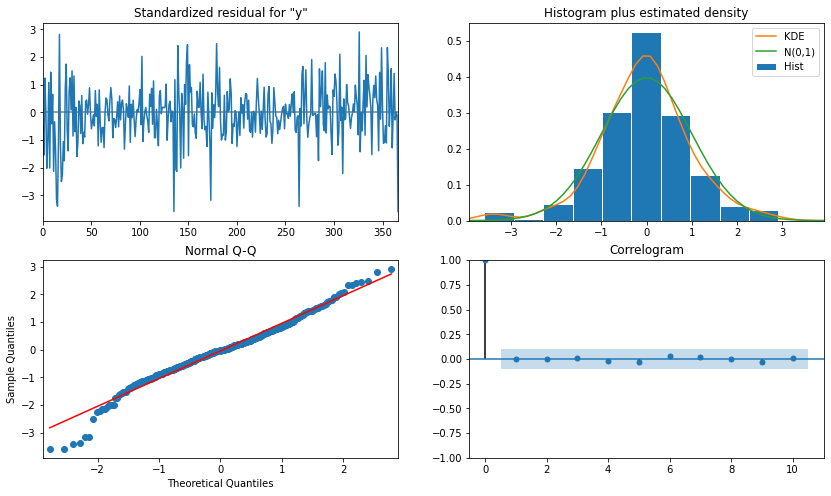

Test RMSE: 18.259


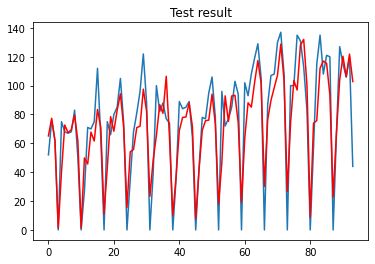

[  0.54774654   0.56990278   0.57468303   0.56009291   0.56464818
   0.56555915 127.55429507]
[  0.54774654   0.56990278   0.57468303   0.56009291   0.56464818
   0.56555915 127.55429507]


In [5]:
predict_res = forecast_func(df)

print(predict_res)